In [2]:
#@title Imports 
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import tjy_udf as tjy
print("tjy_udf: ", list(filter(lambda x: '__' not in x, dir(tjy)))) # Print contained functions
mpl.rc_file('tjy.mplstyle')

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)
DISPLAY_SORTED = True
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib import ticker
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from matplotlib import animation, rc
from scipy.interpolate import UnivariateSpline
    
GIT = 'https://github.com/tyokokur/tmpdat/raw/main/int/'

###COOLWARM COLORMAP DOCUMENTATION  
#https://depts.washington.edu/airqual/coolwarm.m
#Base blue: RGB = [59 76 192]
#Base red:  RGB = [180 4 38]
warm_red = [180/255, 4/255, 38/255]
cool_blue = [59/255,76/255,192/255]
mix_purp = np.divide(np.add(warm_red,cool_blue),2).tolist()

tjy_udf:  ['H_find', 'Kap_D', 'git_sync', 'lighten_color', 'plot_anim', 'plot_pha', 'plot_pha_feed', 'ticks']


In [3]:
def CalcF(nx, y, dx=17/150):
    d = [(i*dx) for i in nx] # Distance from plate to plate
    d1, y1 = [i for ind, i in enumerate(d) if not ind % 2], [i for ind, i in enumerate(y) if not ind % 2]
    d2, y2 = [i for ind, i in enumerate(d) if ind % 2]    , [i for ind, i in enumerate(y) if ind % 2]
    xf, yf = np.average([d1, d2], axis=0), [(y2[i]-y1[i])/(d1[i]-d2[i]) for i in range(round(len(d)/2))] # Force from squeezing (-dx)
    return d, xf, yf

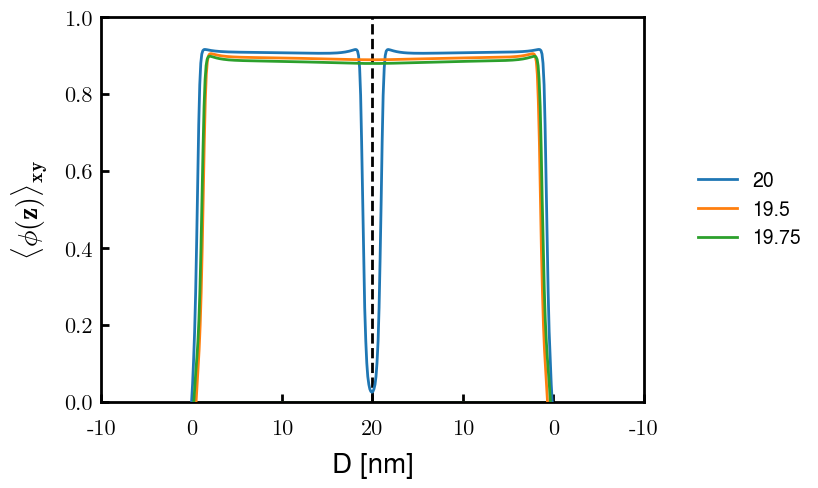

In [4]:
# SYSG Explore
labs = [20, 19.5, 19.75]
read_list = [GIT+'ph_a040d{:05.0f}.dat'.format(i*1000) for i in labs]
max_d = round(max(labs)) #Distance to center (Lx/2)
shifts = [max_d-float(i) for i in labs]
fig, ax = tjy.plot_pha(read_list, x1_shift=shifts,
                       x1_start = -10, x1_end=max_d*2+10, y1_end=1.00, labs=labs, double=False, show=False)
plt.sca(ax)
plt.plot([max_d]*2,[0,1], '--', lw =2, color='k')
step = 10 
plt.xlim(-step, step)
xrange = np.arange(-1*step, max_d*2+step+0.1, step)
xsim = np.concatenate([np.arange(-1*step, max_d+0.1, step), np.arange(max_d-step, -1*(step+0.1), -step)])
plt.xticks(xrange, ['{:.0f}'.format(i) for i in xsim])
plt.xlabel('D [nm]')
plt.legend(frameon=True, framealpha=1.0, facecolor='w', edgecolor='w', loc='center left', bbox_to_anchor=(1.05,0.5))
plt.show()

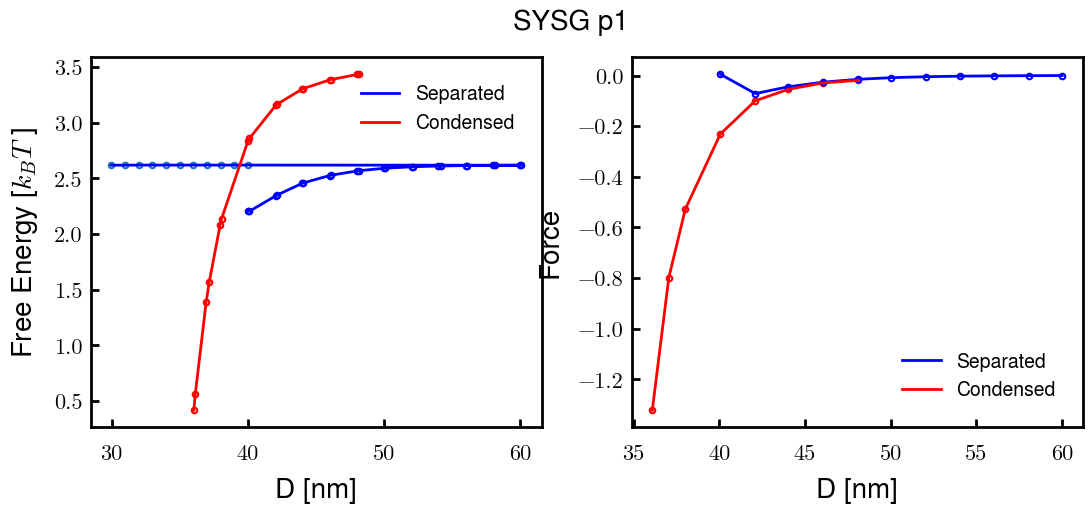

In [5]:
freeE = pd.read_csv(GIT+'p1_4030.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
d4030, y4030 = freeE.nx*17/150/2, freeE.freeE
freeE = pd.read_csv(GIT+'p1_c2520.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, yc2520 = freeE.nx, freeE.freeE
dc2520, xc2520, fc2520 = CalcF(nx, yc2520)
freeE = pd.read_csv(GIT+'p1_s3020.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, ys3020 = freeE.nx, freeE.freeE
ds3020, xs3020, fs3020 = CalcF(nx, ys3020)
freeE = pd.read_csv(GIT+'p1_c1915.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, yc1915 = freeE.nx, freeE.freeE
dc1915, xc1915, fc1915 = CalcF(nx, yc1915)

## Plotting
fs = (plt.rcParams['figure.figsize'][0]*2,  plt.rcParams['figure.figsize'][1])
f, axs = plt.subplots(1,2, figsize=fs)

if 1: 
    axs[0].plot(d4030, y4030, 'o', ms=4, markerfacecolor='none',  c='C0',  label='_4030')
    axs[0].plot(dc2520, yc2520, 'o', ms=4, markerfacecolor='none',  c='red',  label='_c2520')
    axs[0].plot(dc1915, yc1915, 'o', ms=4, markerfacecolor='none', c='red',  label='_c1915')
    axs[0].plot(ds3020, ys3020, 'o', ms=4, markerfacecolor='none',  c='blue',  label='_s3020')
axs[0].plot([*d4030, *ds3020[::-1]], [*y4030, *ys3020[::-1]], c='blue', label='Separated')
axs[0].plot([*dc2520[::-1], *dc1915[::-1]], [*yc2520[::-1], *yc1915[::-1]], c='red', label='Condensed')

if 1:
    axs[1].plot(xc2520, fc2520, 'o', ms=4, markerfacecolor='none', c='red',  label='_c2520')
    axs[1].plot(xc1915, fc1915, 'o', ms=4, markerfacecolor='none', c='red',  label='_c1915')
    axs[1].plot(xs3020, fs3020, 'o', ms=4, markerfacecolor='none', c='blue',  label='_s3020')
axs[1].plot([*xs3020[::-1]], [*fs3020[::-1]], c='blue', label='Separated')
axs[1].plot([*xc2520[::-1], *xc1915[::-1]], [*fc2520[::-1], *fc1915[::-1]], c='red', label='Condensed')

plt.suptitle('SYSG p1', fontsize=20)
axs[0].set_xlabel('D [nm]')
axs[0].set_ylabel('Free Energy 'r'[$k_BT~$]')
axs[0].legend()
axs[1].legend()
axs[1].set_xlabel('D [nm]')
axs[1].set_ylabel('Force')

tjy.ticks(axs)
plt.show()

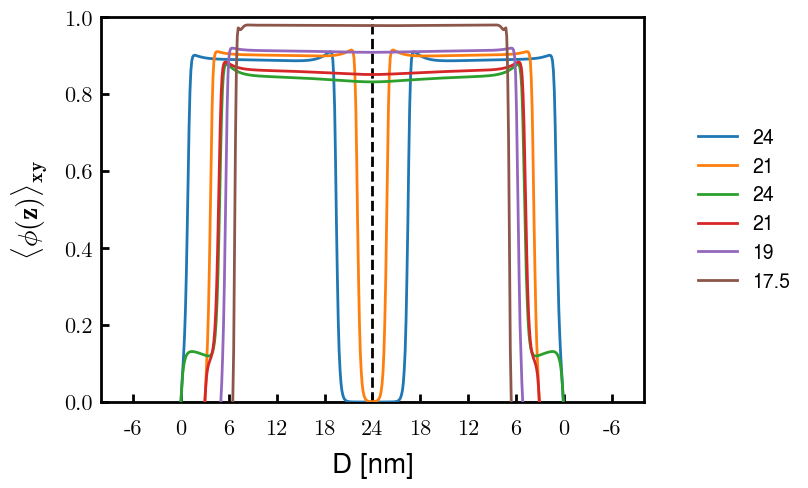

In [6]:
# SYSG 
labs = [24, 21]
read_list = [GIT+'ph_s3020d{:05.0f}.dat'.format(int(i*1000)) for i in labs]
labs2 = [24, 21]
read_list += [GIT+'ph_c2520d{:05.0f}.dat'.format(i*1000) for i in labs2]
labs += labs2
labs2 = [19, 17.5]
read_list += [GIT+'ph_c1915d{:05.0f}.dat'.format(i*1000) for i in labs2]
labs += labs2

max_d = max(labs) #Distance to center (Lx/2)
shifts = [max_d-float(i) for i in labs]
block_Ni = [[5]]*len(read_list)
fig, ax = tjy.plot_pha(read_list, x1_shift=shifts,
                       x1_start = -10, x1_end=max_d*2+10, y1_end=1.00, labs=labs, double=False, show=False)

plt.sca(ax)
plt.plot([max_d]*2,[0,1], '--', lw =2, color='k')
step = 6
xrange = np.arange(-step, max_d*2+step+0.1, step)
xsim = np.concatenate([np.arange(-step, max_d+0.1, step), np.arange(max_d-step, -step-0.1, -step)])
plt.xticks(xrange, ['{:.0f}'.format(i) for i in xsim])
plt.xlabel('D [nm]')
plt.legend(frameon=True, framealpha=1.0, facecolor='w', edgecolor='w', loc='center left', bbox_to_anchor=(1.05,0.5))
plt.show()

In [ ]:
# NFH
labs = [35]
read_list = [GIT+'ph_H30sd{:05d}.dat'.format(int(i*1000)) for i in labs]
labs2 = [20, 10]
read_list += [GIT+'ph_H30cd{:05d}.dat'.format(int(i*1000)) for i in labs2]
labs += labs2
# labs2 = [20, 12.5]
# read_list += [GIT+'ph_H30dd{:05d}.dat'.format(int(i*1000)) for i in labs2]
# labs += labs2

max_d = max(labs) #Distance to center (Lx/2)
shifts = [max_d-float(i) for i in labs]
fig, ax = tjy.plot_pha(read_list, x1_shift=shifts,
                       x1_start = -10, x1_end=max_d*2+10, y1_end=1.00, labs=labs, double=False, show=False)
plt.sca(ax)
plt.plot([max_d]*2,[0,1], '--', lw =2, color='k')
step = 7 
plt.xlim(-step, step)
xrange = np.arange(-1*step, max_d*2+step+0.1, step)
xsim = np.concatenate([np.arange(-1*step, max_d+0.1, step), np.arange(max_d-step, -1*(step+0.1), -step)])
plt.xticks(xrange, ['{:.0f}'.format(i) for i in xsim])
plt.legend(frameon=True, framealpha=1.0, facecolor='w', edgecolor='w', loc='center left', bbox_to_anchor=(1.05,0.5))
plt.show()

In [ ]:
freeE = pd.read_csv(GIT+'NFH_03a.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y03 = freeE.nx, freeE.freeE
d03, x03, f03 = CalcF(nx, y03)
freeE = pd.read_csv(GIT+'NFH_03b.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y03b = freeE.nx, freeE.freeE
d03b, x03b, f03b = CalcF(nx, y03b)
freeE = pd.read_csv(GIT+'NFH_03c.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y03c = freeE.nx, freeE.freeE
d03c, x03c, f03c = CalcF(nx, y03c)
freeE = pd.read_csv(GIT+'NFH_03d.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y03d = freeE.nx, freeE.freeE
d03d, x03d, f03d = CalcF(nx, y03d)
freeE = pd.read_csv(GIT+'NFH_03e.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y03e = freeE.nx, freeE.freeE
d03e, x03e, f03e = CalcF(nx, y03e)

## Plotting
fs = (plt.rcParams['figure.figsize'][0]*2,  plt.rcParams['figure.figsize'][1])
f, axs = plt.subplots(1,2, figsize=fs)
kw = {'marker':'o', 'ls':'none', 'markerfacecolor': 'none', 'ms':4}
if 1: # 1 to plot, 0 to not
    axs[0].plot(d03, y03,   **kw, label='_H04a')
    axs[0].plot(d03b, y03b, **kw, label='_H04b')
    axs[0].plot(d03c, y03c, **kw, label='_H04c')
    axs[0].plot(d03d[:4], y03d[:4], **kw, label='_H04d')
    axs[0].plot(d03e, y03e, **kw, label='_H04e')
tosortd, tosorty = [*d03, *d03b, *d03c], [*y03, *y03b, *y03c]
# axs[0].plot(np.sort(tosortd), np.take_along_axis(np.array(tosorty), np.argsort(tosortd), 0),':', c='C0', label='Separated')
XX, YY = np.sort(tosortd), np.take_along_axis(np.array(tosorty), np.argsort(tosortd), 0)
H_03s = UnivariateSpline(XX, YY, s=8e-8)
tosortd, tosorty = [*d03d[:6], *d03e], [*y03d[:6], *y03e]
# axs[0].plot(np.sort(tosortd), np.take_along_axis(np.array(tosorty), np.argsort(tosortd), 0),':', c='C1', label='Condensed')
XX, YY = np.sort(tosortd), np.take_along_axis(np.array(tosorty), np.argsort(tosortd), 0)
H_03c = UnivariateSpline(XX, YY)

if 1: # 1 to plot, 0 to not
    axs[1].plot(x03, f03,   **kw, label='_H04a')
    axs[1].plot(x03b, f03b, **kw, label='_H04b')
    axs[1].plot(x03c, f03c, **kw, label='_H04c')
    axs[1].plot(x03d[:4], f03d[:4], **kw, label='_H04d')
    axs[1].plot(x03e, f03e, **kw, label='_H04e')
tosortx, tosortf = [*x03, *x03b, *x03c], [*f03, *f03b, *f03c]
# axs[1].plot(np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0),':', c='C0', label='Separated')
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
F_03s = UnivariateSpline(XX, YY, s=8e-8)
tosortx, tosortf = [*x03d[:3], *x03e], [*f03d[:3], *f03e]
# axs[1].plot(np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0),':', c='C1', label='Condensed')
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
F_03c = UnivariateSpline(XX, YY, s=8e-8)

xx = 37.18
axs[0].plot(np.arange(30, xx+0.01, 0.1), H_03s(np.arange(30,xx+0.01,0.1)),':', c='C0', label='_SepMeta')
axs[0].plot(np.arange(xx, 160), H_03s(np.arange(xx,160)), 'C0', label='Separated')
axs[0].plot(np.arange(18, xx+0.01, 0.1), H_03c(np.arange(18,xx+0.01, 0.1)), 'C1', label='Condensed')
axs[0].plot(np.arange(xx, xx+9), H_03c(np.arange(xx, xx+9)),':', c='C1', label='_ConMeta')
# axs[0].plot([xx,xx], [1.45, 1.55], 'k--', lw=1.5)
axs[0].legend()

axs[1].plot(np.arange(30, xx+0.01, 0.1), F_03s(np.arange(30, xx+0.01, 0.1)),':', c='C0', label='_SepMeta')
axs[1].plot(np.arange(xx, 160), F_03s(np.arange(xx,160)), 'C0', label='Separated')
axs[1].plot(np.arange(18, xx+0.01, 0.1), F_03c(np.arange(18, xx+0.01, 0.1)), 'C1', label='Condensed')
axs[1].plot(np.arange(xx, xx+8), F_03c(np.arange(xx,xx+8)),':', c='C1', label='_ConMeta')
axs[1].plot([xx,xx], [-0.0055, 0.005], 'k--', lw=1.5)
axs[1].legend()

axs[0].set_xlabel('D [nm]')
axs[0].set_ylabel('Free Energy 'r'[$k_BT~$]')
axs[1].set_xlabel('D [nm]')
axs[1].set_ylabel('Force')
plt.suptitle('NFH 3 mM', fontsize=20)

tjy.ticks(axs)
plt.show()

In [ ]:
freeE = pd.read_csv(GIT+'NFH_04a.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y04 = freeE.nx, freeE.freeE
d04, x04, f04 = CalcF(nx, y04)
freeE = pd.read_csv(GIT+'NFH_04b.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y04b = freeE.nx, freeE.freeE
d04b, x04b, f04b = CalcF(nx, y04b)
freeE = pd.read_csv(GIT+'NFH_04c.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y04c = freeE.nx, freeE.freeE
d04c, x04c, f04c = CalcF(nx, y04c)
freeE = pd.read_csv(GIT+'NFH_04d.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y04d = freeE.nx, freeE.freeE
d04d, x04d, f04d = CalcF(nx, y04d)
freeE = pd.read_csv(GIT+'NFH_04e.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y04e = freeE.nx, freeE.freeE
d04e, x04e, f04e = CalcF(nx, y04e)

## Plotting
fs = (plt.rcParams['figure.figsize'][0]*2,  plt.rcParams['figure.figsize'][1])
f, axs = plt.subplots(1,2, figsize=fs)
kw = {'marker':'o', 'ls':'none', 'markerfacecolor': 'none', 'ms':4}
if 0: # 1 to plot, 0 to not
    axs[0].plot(d04, y04,   **kw, label='_H04a')
    axs[0].plot(d04b, y04b, **kw, label='_H04b')
    axs[0].plot(d04c, y04c, **kw, label='_H04c')
    axs[0].plot(d04d[:4], y04d[:4], **kw, label='_H04d')
    axs[0].plot(d04e, y04e, **kw, label='_H04e')
tosortd, tosorty = [*d04, *d04b, *d04c], [*y04, *y04b, *y04c]
# axs[0].plot(np.sort(tosortd), np.take_along_axis(np.array(tosorty), np.argsort(tosortd), 0),':', c='C0', label='Separated')
XX, YY = np.sort(tosortd), np.take_along_axis(np.array(tosorty), np.argsort(tosortd), 0)
H_04s = UnivariateSpline(XX, YY, s=8e-8)
tosortd, tosorty = [*d04d[:6], *d04e], [*y04d[:6], *y04e]
# axs[0].plot(np.sort(tosortd), np.take_along_axis(np.array(tosorty), np.argsort(tosortd), 0),':', c='C1', label='Condensed')
XX, YY = np.sort(tosortd), np.take_along_axis(np.array(tosorty), np.argsort(tosortd), 0)
H_04c = UnivariateSpline(XX, YY)

if 1: # 1 to plot, 0 to not
    axs[1].plot(x04, f04,   **kw, label='_H04a')
    axs[1].plot(x04b, f04b, **kw, label='_H04b')
    axs[1].plot(x04c, f04c, **kw, label='_H04c')
    axs[1].plot(x04d[:4], f04d[:4], **kw, label='_H04d')
    axs[1].plot(x04e, f04e, **kw, label='_H04e')
tosortx, tosortf = [*x04, *x04b, *x04c], [*f04, *f04b, *f04c]
# axs[1].plot(np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0),':', c='C0', label='Separated')
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
F_04s = UnivariateSpline(XX, YY, s=8e-8)
tosortx, tosortf = [*x04d[:3], *x04e], [*f04d[:3], *f04e]
# axs[1].plot(np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0),':', c='C1', label='Condensed')
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
F_04c = UnivariateSpline(XX, YY, s=8e-8)

xx = 37.62
axs[0].plot(np.arange(30, xx+0.01, 0.1), H_04s(np.arange(30,xx+0.01,0.1)),':', c='C0', label='_SepMeta')
axs[0].plot(np.arange(xx, 160), H_04s(np.arange(xx,160)), 'C0', label='Separated')
axs[0].plot(np.arange(18, xx+0.01, 0.1), H_04c(np.arange(18,xx+0.01, 0.1)), 'C1', label='Condensed')
axs[0].plot(np.arange(xx, xx+9), H_04c(np.arange(xx, xx+9)),':', c='C1', label='_ConMeta')
# axs[0].plot([xx,xx], [1.45, 1.55], 'k--', lw=1.5)
axs[0].legend()

axs[1].plot(np.arange(30, xx+0.01, 0.1), F_04s(np.arange(30, xx+0.01, 0.1)),':', c='C0', label='_SepMeta')
axs[1].plot(np.arange(xx, 160), F_04s(np.arange(xx,160)), 'C0', label='Separated')
axs[1].plot(np.arange(18, xx+0.01, 0.1), F_04c(np.arange(18, xx+0.01, 0.1)), 'C1', label='Condensed')
axs[1].plot(np.arange(xx, xx+8), F_04c(np.arange(xx,xx+8)),':', c='C1', label='_ConMeta')
axs[1].plot([xx,xx], [-0.0055, 0.005], 'k--', lw=1.5)
axs[1].legend()

axs[0].set_xlabel('D [nm]')
axs[0].set_ylabel('Free Energy 'r'[$k_BT~$]')
axs[1].set_xlabel('D [nm]')
axs[1].set_ylabel('Force')
plt.suptitle('NFH 4 mM', fontsize=20)

tjy.ticks(axs)
plt.show()

In [ ]:
freeE = pd.read_csv(GIT+'NFH_05a.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y05 = freeE.nx, freeE.freeE
d05, x05, f05 = CalcF(nx, y05)
freeE = pd.read_csv(GIT+'NFH_05b.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y05b = freeE.nx, freeE.freeE
d05b, x05b, f05b = CalcF(nx, y05b)
freeE = pd.read_csv(GIT+'NFH_05c.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y05c = freeE.nx, freeE.freeE
d05c, x05c, f05c = CalcF(nx, y05c)
freeE = pd.read_csv(GIT+'NFH_05d.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y05d = freeE.nx, freeE.freeE
d05d, x05d, f05d = CalcF(nx, y05d)
freeE = pd.read_csv(GIT+'NFH_05e.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y05e = freeE.nx, freeE.freeE
d05e, x05e, f05e = CalcF(nx, y05e)

## Plotting
fs = (plt.rcParams['figure.figsize'][0]*2,  plt.rcParams['figure.figsize'][1])
f, axs = plt.subplots(1,2, figsize=fs)
kw = {'marker':'o', 'ls':'none', 'markerfacecolor': 'none', 'ms':4}
if 0: # 1 to plot, 0 to not
    axs[0].plot(d05, y05,   **kw, label='_H05a')
    axs[0].plot(d05b, y05b, **kw, label='_H05b')
    axs[0].plot(d05c, y05c, **kw, label='_H05c')
    axs[0].plot(d05d[:4], y05d[:4], **kw, label='_H05d')
    axs[0].plot(d05e, y05e, **kw, label='_H05e')
tosortd, tosorty = [*d05, *d05b, *d05c], [*y05, *y05b, *y05c]
# axs[0].plot(np.sort(tosortd), np.take_along_axis(np.array(tosorty), np.argsort(tosortd), 0),':', c='C0', label='Separated')
XX, YY = np.sort(tosortd), np.take_along_axis(np.array(tosorty), np.argsort(tosortd), 0)
H_05s = UnivariateSpline(XX, YY, s=8e-8)
tosortd, tosorty = [*d05d[:6], *d05e], [*y05d[:6], *y05e]
# axs[0].plot(np.sort(tosortd), np.take_along_axis(np.array(tosorty), np.argsort(tosortd), 0),':', c='C1', label='Condensed')
XX, YY = np.sort(tosortd), np.take_along_axis(np.array(tosorty), np.argsort(tosortd), 0)
H_05c = UnivariateSpline(XX, YY)

if 1: # 1 to plot, 0 to not
    axs[1].plot(x05, f05,   **kw, label='_H05a')
    axs[1].plot(x05b, f05b, **kw, label='_H05b')
    axs[1].plot(x05c, f05c, **kw, label='_H05c')
    axs[1].plot(x05d[:4], f05d[:4], **kw, label='_H05d')
    axs[1].plot(x05e, f05e, **kw, label='_H05e')
tosortx, tosortf = [*x05, *x05b, *x05c], [*f05, *f05b, *f05c]
# axs[1].plot(np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0),':', c='C0', label='Separated')
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
F_05s = UnivariateSpline(XX, YY, s=8e-8)
tosortx, tosortf = [*x05d[:3], *x05e], [*f05d[:3], *f05e]
# axs[1].plot(np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0),':', c='C1', label='Condensed')
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
F_05c = UnivariateSpline(XX, YY, s=8e-8)

xx = 37.62
axs[0].plot(np.arange(30, xx+0.01, 0.1), H_05s(np.arange(30,xx+0.01,0.1)),':', c='C0', label='_SepMeta')
axs[0].plot(np.arange(xx, 160), H_05s(np.arange(xx,160)), 'C0', label='Separated')
axs[0].plot(np.arange(18, xx+0.01, 0.1), H_05c(np.arange(18,xx+0.01, 0.1)), 'C1', label='Condensed')
axs[0].plot(np.arange(xx, xx+9), H_05c(np.arange(xx, xx+9)),':', c='C1', label='_ConMeta')
# axs[0].plot([xx,xx], [1.45, 1.55], 'k--', lw=1.5)
axs[0].legend()

axs[1].plot(np.arange(30, xx+0.01, 0.1), F_05s(np.arange(30, xx+0.01, 0.1)),':', c='C0', label='_SepMeta')
axs[1].plot(np.arange(xx, 160), F_05s(np.arange(xx,160)), 'C0', label='Separated')
axs[1].plot(np.arange(18, xx+0.01, 0.1), F_05c(np.arange(18, xx+0.01, 0.1)), 'C1', label='Condensed')
axs[1].plot(np.arange(xx, xx+8), F_05c(np.arange(xx,xx+8)),':', c='C1', label='_ConMeta')
axs[1].plot([xx,xx], [-0.0055, 0.005], 'k--', lw=1.5)
axs[1].legend()

axs[0].set_xlabel('D [nm]')
axs[0].set_ylabel('Free Energy 'r'[$k_BT~$]')
axs[1].set_xlabel('D [nm]')
axs[1].set_ylabel('Force')
plt.suptitle('NFH 5 mM', fontsize=20)

tjy.ticks(axs)
plt.show()

In [ ]:
freeE = pd.read_csv(GIT+'NFH_06a.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y06a = freeE.nx, freeE.freeE
d06a, x06a, f06a = CalcF(nx, y06a)
freeE = pd.read_csv(GIT+'NFH_06b.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y06b = freeE.nx, freeE.freeE
d06b, x06b, f06b = CalcF(nx, y06b)
freeE = pd.read_csv(GIT+'NFH_06c.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y06c = freeE.nx, freeE.freeE
d06c, x06c, f06c = CalcF(nx, y06c)
freeE = pd.read_csv(GIT+'NFH_06d.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y06d = freeE.nx, freeE.freeE
d06d, x06d, f06d = CalcF(nx, y06d)

## Plotting
fs = (plt.rcParams['figure.figsize'][0]*2,  plt.rcParams['figure.figsize'][1])
f, axs = plt.subplots(1,2, figsize=fs)
kw = {'marker':'o', 'ls':'none', 'markerfacecolor': 'none', 'ms':4}
if 0: 
    axs[0].plot(d06a, y06a, **kw, label='_H06a')
    axs[0].plot(d06b, y06b, **kw, label='_H06b')
    axs[0].plot(d06c, y06c, **kw, label='_H06c')
    axs[0].plot(d06d, y06d, **kw, label='_H06d')
tosortx, tosortf = [*d06a, *d06b, *d06c[-16:]], [*y06a, *y06b, *y06c[-16:]]
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
H_06s = UnivariateSpline(XX, YY, s=8e-8)
tosortx, tosortf = [*d06c[:-16], *d06d], [*y06c[:-16], *y06d]
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
H_06c = UnivariateSpline(XX, YY, s=8e-8)
# axs[0].plot([*d06c[-16:], *d06a, *d06b], [*y06c[-16:], *y06a, *y06b], c='C0')
# axs[0].plot([*d06c[:-16], *d06d], [*y06c[:-16], *y06d], c='C1')

if 1: 
    axs[1].plot(x06a, f06a, **kw, label='_F06a')
    axs[1].plot(x06b, f06b, **kw, label='_F06b')
    axs[1].plot(x06c, f06c, **kw, label='_F06c')
    axs[1].plot(x06d, f06d, **kw, label='_F06d')
tosortx, tosortf = [*x06a[4:], *x06b], [*f06a[4:], *f06b]
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
F_06s = UnivariateSpline(XX, YY, s=2e-08)
tosortx, tosortf = [*x06c[4:-8], *x06d], [*f06c[4:-8], *f06d]
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
F_06c = UnivariateSpline(XX, YY, s=1e-08)
# axs[1].plot([*x06c[-8:], *x06a, *x06b], [*f06c[-8:], *f06a, *f06b], c='C0')
# axs[1].plot([*x06c[:-8], *x06d], [*f06c[:-8], *f06d], c='C1')

xx = 39.735
axs[0].plot(np.arange(xx-8, xx+0.01, 0.1), H_06s(np.arange(xx-8, xx+0.01, 0.1)), ':', c='C0', label='_SepMeta') 
axs[0].plot(np.arange(xx, 160), H_06s(np.arange(xx, 160)), c='C0', label='Separated') 
axs[0].plot(np.arange(18, xx+0.01, 0.1), H_06c(np.arange(18, xx+0.01, 0.1)), c='C1', label='Condensed') 
axs[0].plot(np.arange(xx, xx+5.5), H_06c(np.arange(xx, xx+5.5)),':', c='C1', label='_ConMeta') 
axs[0].legend()

axs[1].plot(np.arange(xx-8, xx+0.01, 0.1), F_06s(np.arange(xx-8, xx+0.01, 0.1)), ':', c='C0', label='_SepMeta') 
axs[1].plot(np.arange(xx, 120), F_06s(np.arange(xx, 120)), c='C0', label='Separated') 
axs[1].plot(np.arange(120, 161, 20), [0]*3, c='C0', label='_Separated') 
axs[1].plot(np.arange(18, xx+0.01, 0.1), F_06c(np.arange(18, xx+0.01, 0.1)), c='C1', label='Condensed') 
axs[1].plot(np.arange(xx, xx+10), F_06c(np.arange(xx, xx+10)),':', c='C1', label='_ConMeta') 
axs[1].plot([xx,xx], [-0.0059, 0.0031],'k--', lw=1.5)
axs[1].legend()
                                                
axs[0].set_xlabel('D [nm]')
axs[0].set_ylabel('Free Energy 'r'[$k_BT~$]')
axs[1].set_xlabel('D [nm]')
axs[1].set_ylabel('Force')
plt.suptitle('NFH 6 mM', fontsize=20)

tjy.ticks(axs)
plt.show()

In [ ]:
freeE = pd.read_csv(GIT+'NFH_10a.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y10a = freeE.nx, freeE.freeE
d10a, x10a, f10a = CalcF(nx, y10a)
freeE = pd.read_csv(GIT+'NFH_10b.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y10b = freeE.nx, freeE.freeE
d10b, x10b, f10b = CalcF(nx, y10b)
freeE = pd.read_csv(GIT+'NFH_10c.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y10c = freeE.nx, freeE.freeE
d10c, x10c, f10c = CalcF(nx, y10c)
freeE = pd.read_csv(GIT+'NFH_10d.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, y10d = freeE.nx, freeE.freeE
d10d, x10d, f10d = CalcF(nx, y10d)

## Plotting
fs = (plt.rcParams['figure.figsize'][0]*2,  plt.rcParams['figure.figsize'][1])
f, axs = plt.subplots(1,2, figsize=fs)
kw = {'marker':'o', 'ls':'none', 'markerfacecolor': 'none', 'ms':4}
if 0: 
    axs[0].plot(d10a, y10a, **kw, label='_H10a')
    axs[0].plot(d10b, y10b, **kw, label='_H10b')
    axs[0].plot(d10c, y10c, **kw, label='_H10c')
    axs[0].plot(d10d, y10d, **kw, label='_H10d')
tosortx, tosortf = [*d10a, *d10b, *d10c[28:]], [*y10a, *y10b, *y10c[28:]]
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
H_10s = UnivariateSpline(XX, YY, s=8e-8)
tosortx, tosortf = [*d10c[:26], *d10d[:-2]], [*y10c[:26], *y10d[:-2]]
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
H_10c = UnivariateSpline(XX, YY, s=8e-8)

if 1: 
    axs[1].plot(x10a, f10a, **kw, label='_F10a')
    axs[1].plot(x10b, f10b, **kw, label='_F10b')
    axs[1].plot(x10c[:13], f10c[:13], **kw, label='_F10c') # ind 14 is wrong conf
    axs[1].plot(x10c[15:], f10c[15:], **kw, label='_F10c') # ind 14 is wrong conf
    axs[1].plot(x10d, f10d, **kw, label='_F10d')
tosortx, tosortf = [*x10a, *x10b, *x10c[28:]], [*f10a, *f10b, *f10c[28:]]
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
F_10s = UnivariateSpline(XX, YY, s=8e-08)
tosortx, tosortf = [*x10c[:13], *x10d], [*f10c[:13], *f10d]
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
F_10c = UnivariateSpline(XX, YY, s=8e-08)

xx = 46.35
axs[0].plot(np.arange(xx-8, xx+0.01, 0.1), H_10s(np.arange(xx-8, xx+0.01, 0.1)), ':', c='C0', label='_SepMeta') 
axs[0].plot(np.arange(xx, 160), H_10s(np.arange(xx, 160)), c='C0', label='Separated') 
axs[0].plot(np.arange(18, xx+0.01, 0.1), H_10c(np.arange(18, xx+0.01, 0.1)), c='C1', label='Condensed') 
axs[0].plot(np.arange(xx, xx+5.5), H_10c(np.arange(xx, xx+5.5)),':', c='C1', label='_ConMeta') 
axs[0].legend()
# axs[0].set_xlim(46, 47)
# axs[0].set_ylim(1.36, 1.38)

axs[1].plot(np.arange(xx-8, xx+0.01, 0.1), F_10s(np.arange(xx-8, xx+0.01, 0.1)), ':', c='C0', label='_SepMeta') 
axs[1].plot(np.arange(xx, 81), F_10s(np.arange(xx, 81)), c='C0', label='Separated') 
axs[1].plot(np.arange(80, 161, 20), [0]*5, c='C0', label='_Separated') 
axs[1].plot(np.arange(18, xx+0.01, 0.1), F_10c(np.arange(18, xx+0.01, 0.1)), c='C1', label='Condensed') 
axs[1].plot(np.arange(xx, xx+10), F_10c(np.arange(xx, xx+10)),':', c='C1', label='_ConMeta') 
axs[1].plot([xx,xx], [-0.0059, 0.0005],'k--', lw=1.5)
axs[1].legend()
                                                
axs[0].set_xlabel('D [nm]')
axs[0].set_ylabel('Free Energy 'r'[$k_BT~$]')
axs[1].set_xlabel('D [nm]')
axs[1].set_ylabel('Force')
plt.suptitle('NFH 10 mM', fontsize=20)

tjy.ticks(axs)
plt.show()

In [ ]:
freeE = pd.read_csv(GIT+'NFH_20s.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, ys = freeE.nx, freeE.freeE
ds, x20s, y20s = CalcF(nx, ys)
freeE = pd.read_csv(GIT+'NFH_20c.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, yc = freeE.nx, freeE.freeE
dc, x20c, y20c = CalcF(nx, yc)
freeE = pd.read_csv(GIT+'NFH_20c2.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, yc2 = freeE.nx, freeE.freeE
dc2, x20c2, y20c2 = CalcF(nx, yc2)

## Plotting
fs = (plt.rcParams['figure.figsize'][0]*2,  plt.rcParams['figure.figsize'][1])
f, axs = plt.subplots(1,2, figsize=fs)
kw = {'marker':'o', 'ls':'none', 'markerfacecolor': 'none', 'ms':4}
if 1: 
    axs[0].plot(ds, ys,   **kw, label='_NFHs')
    axs[0].plot(dc, yc,   **kw, label='_NFHc')
    axs[0].plot(dc2, yc2, **kw, label='_NFHc2')
tosortx, tosortf = ds, ys 
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
H_20s = UnivariateSpline(XX, YY, s=8e-08)
tosortx, tosortf = [*dc, *dc2], [*yc, *yc2]
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
H_20c = UnivariateSpline(XX, YY, s=8e-08)

if 1: 
    axs[1].plot(x20s, y20s, **kw, label='_NFHs')
    axs[1].plot(x20c[5:], y20c[5:], **kw, label='_NFHc')
    axs[1].plot(x20c2, y20c2, **kw, label='_NFHc')
tosortx, tosortf = x20s, y20s 
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
F_20s = UnivariateSpline(XX, YY, s=8e-08)
tosortx, tosortf = [*x20c[5:], *x20c2], [*y20c[5:], *y20c2]
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
F_20c = UnivariateSpline(XX, YY, s=8e-08)

xx = 57.94
axs[0].plot(np.arange(xx-10, xx+0.01, 0.1), H_20s(np.arange(xx-10, xx+0.01, 0.1)), ':', c='C0', label='_SepMeta') 
axs[0].plot(np.arange(xx, 60), H_20s(np.arange(xx, 60)), c='C0', label='Separated') 
axs[0].plot(np.arange(60, 161, 20), H_20s([60]).tolist()*6, c='C0', label='Separated') 
axs[0].plot(np.arange(18, xx+0.01, 0.1), H_20c(np.arange(18, xx+0.01, 0.1)), c='C1', label='Condensed') 
axs[0].plot(np.arange(xx, xx+5.5), H_20c(np.arange(xx, xx+5.5)),':', c='C1', label='_ConMeta') 
axs[0].legend()

axs[1].plot(np.arange(xx-10, xx+0.01, 0.1), F_20s(np.arange(xx-10, xx+0.01, 0.1)), ':', c='C0', label='_SepMeta') 
# axs[1].plot(np.arange(xx, 100), F_20s(np.arange(xx, 100)), c='C0', label='Separated') 
axs[1].plot(np.arange(xx, 161, 20), len(np.arange(xx,161,20))*[0], c='C0', label='Separated')
axs[1].plot(np.arange(18, xx+0.01, 0.1), F_20c(np.arange(18, xx+0.01, 0.1)), c='C1', label='Condensed') 
axs[1].plot(np.arange(xx, xx+10), F_20c(np.arange(xx, xx+10)),':', c='C1', label='_ConMeta') 
axs[1].plot([xx,xx], [-0.0064, 0.00],'k--', lw=1.5)
axs[1].legend()

axs[0].set_xlabel('D [nm]')
axs[0].set_ylabel('Free Energy 'r'[$k_BT~$]')
axs[1].set_xlabel('D [nm]')
axs[1].set_ylabel('Force')
plt.suptitle('NFH 20 mM', fontsize=20)

tjy.ticks(axs)
plt.show()

In [ ]:
freeE = pd.read_csv(GIT+'NFH_30s.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, ys = freeE.nx, freeE.freeE
ds, x30s, y30s = CalcF(nx, ys)
freeE = pd.read_csv(GIT+'NFH_30c.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, yc = freeE.nx, freeE.freeE
dc, x30c, y30c = CalcF(nx, yc)
freeE = pd.read_csv(GIT+'NFH_30c2.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, yc2 = freeE.nx, freeE.freeE
dc2, x30c2, y30c2 = CalcF(nx, yc2)

## Plotting
fs = (plt.rcParams['figure.figsize'][0]*2,  plt.rcParams['figure.figsize'][1])
f, axs = plt.subplots(1,2, figsize=fs)
kw = {'marker':'o', 'ls':'none', 'markerfacecolor': 'none', 'ms':4}
if 0: 
    axs[0].plot(ds, ys,   **kw, label='_NFHs')
    axs[0].plot(dc, yc,   **kw, label='_NFHc')
    axs[0].plot(dc2, yc2, **kw, label='_NFHc2')
tosortx, tosortf = ds, ys 
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
H_30s = UnivariateSpline(XX, YY, s=8e-08)
tosortx, tosortf = [*dc, *dc2], [*yc, *yc2]
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
H_30c = UnivariateSpline(XX, YY, s=8e-08)

if 0: 
    axs[1].plot(x30s, y30s, **kw, label='_NFHs')
    axs[1].plot(x30c[5:], y30c[5:], **kw, label='_NFHc')
    axs[1].plot(x30c2, y30c2, **kw, label='_NFHc')
tosortx, tosortf = x30s, y30s 
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
F_30s = UnivariateSpline(XX, YY, s=8e-08)
tosortx, tosortf = [*x30c[5:], *x30c2], [*y30c[5:], *y30c2]
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
F_30c = UnivariateSpline(XX, YY, s=8e-08)

xx = 63.25
axs[0].plot(np.arange(xx-10, xx+0.01, 0.1), H_30s(np.arange(xx-10, xx+0.01, 0.1)), ':', c='C0', label='_SepMeta') 
# axs[0].plot(np.arange(xx, 60), H_30s(np.arange(xx, 60)), c='C0', label='Separated') 
axs[0].plot(np.arange(xx, 164, 20), H_30s([60]).tolist()*6, c='C0', label='Separated') 
axs[0].plot(np.arange(18, xx+0.01, 0.1), H_30c(np.arange(18, xx+0.01, 0.1)), c='C1', label='Condensed') 
axs[0].plot(np.arange(xx, xx+5.5), H_30c(np.arange(xx, xx+5.5)),':', c='C1', label='_ConMeta') 
axs[0].legend()

axs[1].plot(np.arange(xx-10, xx+0.01, 0.1), F_30s(np.arange(xx-10, xx+0.01, 0.1)), ':', c='C0', label='_SepMeta') 
# axs[1].plot(np.arange(xx, 100), F_30s(np.arange(xx, 100)), c='C0', label='Separated') 
axs[1].plot(np.arange(xx, 161, 20), len(np.arange(xx,161,20))*[0], c='C0', label='Separated')
axs[1].plot(np.arange(18, xx+0.01, 0.1), F_30c(np.arange(18, xx+0.01, 0.1)), c='C1', label='Condensed') 
axs[1].plot(np.arange(xx, xx+10), F_30c(np.arange(xx, xx+10)),':', c='C1', label='_ConMeta') 
axs[1].plot([xx,xx], [-0.0064, 0.00],'k--', lw=1.5)
axs[1].legend()

axs[0].set_xlabel('D [nm]')
axs[0].set_ylabel('Free Energy 'r'[$k_BT~$]')
axs[1].set_xlabel('D [nm]')
axs[1].set_ylabel('Force')
plt.suptitle('NFH 30 mM', fontsize=20)

tjy.ticks(axs)
plt.show()

In [ ]:
freeE = pd.read_csv(GIT+'NFH_50s.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, ys = freeE.nx, freeE.freeE
ds, x50s, y50s = CalcF(nx, ys)
freeE = pd.read_csv(GIT+'NFH_50c.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, yc = freeE.nx, freeE.freeE
dc, x50c, y50c = CalcF(nx, yc)
freeE = pd.read_csv(GIT+'NFH_50c2.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, yc2 = freeE.nx, freeE.freeE
dc2, x50c2, y50c2 = CalcF(nx, yc2)

## Plotting
fs = (plt.rcParams['figure.figsize'][0]*2,  plt.rcParams['figure.figsize'][1])
f, axs = plt.subplots(1,2, figsize=fs)
kw = {'marker':'o', 'ls':'none', 'markerfacecolor': 'none', 'ms':4}
if 0: 
    axs[0].plot(ds, ys,   **kw, label='_NFHs')
    axs[0].plot(dc, yc,   **kw, label='_NFHc')
    axs[0].plot(dc2, yc2, **kw, label='_NFHc2')
tosortx, tosortf = ds, ys 
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
H_50s = UnivariateSpline(XX, YY, s=8e-08)
tosortx, tosortf = [*dc, *dc2], [*yc, *yc2]
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
H_50c = UnivariateSpline(XX, YY, s=1e-08)
# axs[0].plot(ds, ys, c='C0', label='Separated')
# axs[0].plot([*dc, *dc2], [*yc, *yc2], c='C1', label='Condensed')

if 1: 
    axs[1].plot(x50s, y50s, **kw, label='_NFHs')
    axs[1].plot(x50c[5:], y50c[5:], **kw, label='_NFHc')
    axs[1].plot(x50c2, y50c2, **kw, label='_NFHc')
tosortx, tosortf = x50s, y50s 
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
F_50s = UnivariateSpline(XX, YY, s=8e-08)
tosortx, tosortf = [*x50c[5:], *x50c2], [*y50c[5:], *y50c2]
XX, YY = np.sort(tosortx), np.take_along_axis(np.array(tosortf), np.argsort(tosortx), 0)
F_50c = UnivariateSpline(XX, YY, s=6e-08)
# axs[1].plot(x50s, y50s, c='C0', label='Separated')
# axs[1].plot([*x50c, *x50c2], [*y50c, *y50c2], c='C1', label='Condensed')

xx = 68.85
axs[0].plot(np.arange(xx-10, xx+0.01, 0.1), H_50s(np.arange(xx-10, xx+0.01, 0.1)), ':', c='C0', label='_SepMeta') 
axs[0].plot(np.arange(xx, 160), H_50s(np.arange(xx, 160)), c='C0', label='Separated') 
axs[0].plot(np.arange(18, xx+0.01, 0.1), H_50c(np.arange(18, xx+0.01, 0.1)), c='C1', label='Condensed') 
axs[0].plot(np.arange(xx, xx+5.5), H_50c(np.arange(xx, xx+5.5)),':', c='C1', label='_ConMeta') 
axs[0].legend()

axs[1].plot(np.arange(xx-10, xx+0.01, 0.1), F_50s(np.arange(xx-10, xx+0.01, 0.1)), ':', c='C0', label='_SepMeta') 
# axs[1].plot(np.arange(xx, 100), F_50s(np.arange(xx, 100)), c='C0', label='Separated') 
axs[1].plot(np.arange(xx, 161, 20), len(np.arange(xx,161,20))*[0], c='C0', label='Separated')
axs[1].plot(np.arange(18, xx+0.01, 0.1), F_50c(np.arange(18, xx+0.01, 0.1)), c='C1', label='Condensed') 
axs[1].plot(np.arange(xx, xx+10), F_50c(np.arange(xx, xx+10)),':', c='C1', label='_ConMeta') 
axs[1].plot([xx,xx], [-0.0067, 0.00],'k--', lw=1.5)
axs[1].legend()

axs[0].set_xlabel('D [nm]')
axs[0].set_ylabel('Free Energy 'r'[$k_BT~$]')
axs[1].set_xlabel('D [nm]')
axs[1].set_ylabel('Force')
plt.suptitle('NFH 50 mM', fontsize=20)

tjy.ticks(axs)
plt.show()

In [ ]:
## Plotting
f, ax = plt.subplots(1,1)
cividis = mpl.colormaps['magma'].resampled(11)(range(8,0,-1))
pas = 4.04e-03 # Scaling to get from kBT/nm^3 to Pascals 
scaling = 5 # For order unity y-axis
pas *= 10**scaling

# NFH 50
xx = 68.85
c = cividis[7]
# plt.plot(np.arange(xx-10, xx+0.01, 0.1), F_50s(np.arange(xx-10, xx+0.01, 0.1)), ':', c=c, label='_SepMeta') 
# axs[1].plot(np.arange(xx, 100), F_50s(np.arange(xx, 100)), c='C0', label='Separated') 
plt.plot(np.arange(60, 161, 20),      len(np.arange(60,161,20))*[0], c=c, label='50 mM')
plt.plot(np.arange(20, xx+0.01, 0.1), pas*F_50c(np.arange(20, xx+0.01, 0.1)), c=c, label='_Condensed') 
plt.plot(np.arange(xx, xx+10),        pas*F_50c(np.arange(xx, xx+10)),':', c=c, label='_ConMeta') 
plt.plot([xx,xx], [pas*-0.0067, 0.00], '--', c=c, lw=1.5)

# # NFH 30
# xx = 63.25
# c = cividis[6]
# plt.plot(np.arange(xx-10, xx+0.01, 0.1), pas*F_30s(np.arange(xx-10, xx+0.01, 0.1)), ':', c=c, label='_SepMeta') 
# # axs[1].plot(np.arange(xx, 100), F_30s(np.arange(xx, 100)), c='C0', label='Separated') 
# plt.plot(np.arange(60, 161, 20),         len(np.arange(60,161,20))*[0], c=c, label='30 mM')
# plt.plot(np.arange(20, xx+0.01, 0.1),    pas*F_30c(np.arange(20, xx+0.01, 0.1)), c=c, label='_Condensed') 
# plt.plot(np.arange(xx, xx+10),           pas*F_30c(np.arange(xx, xx+10)),':', c=c, label='_ConMeta') 
# plt.plot([xx,xx], [pas*-0.0064, 0.00], '--', c=c, lw=1.5)

# NFH 20
xx = 57.94
c = cividis[5]
plt.plot(np.arange(xx-10, xx+0.01, 0.1), pas*F_20s(np.arange(xx-10, xx+0.01, 0.1)), ':', c=c, label='_SepMeta') 
plt.plot(np.arange(xx, 161, 20),         len(np.arange(xx,161,20))*[0], c=c, label='20 mM')
plt.plot(np.arange(20, xx+0.01, 0.1),    pas*F_20c(np.arange(20, xx+0.01, 0.1)), c=c, label='_Condensed') 
plt.plot(np.arange(xx, xx+10),           pas*F_20c(np.arange(xx, xx+10)),':', c=c, label='_ConMeta') 
plt.plot([xx,xx], [pas*-0.0062, 0.00],'--', c=c, lw=1.5)

# NFH 10
xx = 46.35
c = cividis[4]
plt.plot(np.arange(xx-8, xx+0.01, 0.1), pas*F_10s(np.arange(xx-8, xx+0.01, 0.1)), ':', c=c, label='_SepMeta') 
plt.plot(np.arange(xx, 81),             pas*F_10s(np.arange(xx, 81)), c=c, label='10 mM') 
plt.plot(np.arange(80, 161, 20), [0]*5, c=c, label='_Separated') 
plt.plot(np.arange(20, xx+0.01, 0.1),   pas*F_10c(np.arange(20, xx+0.01, 0.1)), c=c, label='_Condensed') 
plt.plot(np.arange(xx, xx+10),          pas*F_10c(np.arange(xx, xx+10)),':', c=c, label='_ConMeta') 
plt.plot([xx,xx], [pas*-0.0059, pas*0.0005], '--',c=c,lw=1.5)

# NFH 06
xx = 39.735
c = cividis[2]
plt.plot(np.arange(xx-8, xx+0.01, 0.1), pas*F_06s(np.arange(xx-8, xx+0.01, 0.1)), ':', c=c, label='_SepMeta') 
plt.plot(np.arange(xx, 120),            pas*F_06s(np.arange(xx, 120)), c=c, label='6 mM') 
plt.plot(np.arange(120, 161, 20), [0]*3, c=c, label='_Separated') 
plt.plot(np.arange(20, xx+0.01, 0.1),   pas*F_06c(np.arange(20, xx+0.01, 0.1)), c=c, label='_Condensed') 
plt.plot(np.arange(xx, xx+10),          pas*F_06c(np.arange(xx, xx+10)),':', c=c, label='_ConMeta') 
plt.plot([xx,xx], [pas*-0.0059, pas*0.0031],'--', c=c, lw=1.5)

# Splitting start #
# end = 120
# step = 70
# plt.plot(np.arange(xx, step),            0.7+pas*F_06s(np.arange(xx, step)), c='red', label='_Shifted 6 mM') 
# plt.plot(np.arange(step+40, end+40),            pas*F_06s(np.arange(step, end)), c='red', label='Shifted 6 mM') 
###################

# NFH 05
# xx = 37.62
# c = cividis[2]
# plt.plot(np.arange(30, xx+0.01, 0.1), pas*F_05s(np.arange(30, xx+0.01, 0.1)),':', c=c, label='_SepMeta')
# plt.plot(np.arange(xx, 161),          pas*F_05s(np.arange(xx,161)), c=c, label='5 mM')
# plt.plot(np.arange(20, xx+0.01, 0.1), pas*F_05c(np.arange(20, xx+0.01, 0.1)), c=c, label='_Condensed')
# plt.plot(np.arange(xx, xx+8),         pas*F_05c(np.arange(xx,xx+8)),':', c=c, label='_ConMeta')
# plt.plot([xx,xx], [pas*-0.0055, pas*0.005], '--', c=c, lw=1.5)

# NFH 04
xx = 37.62
c = cividis[0]
plt.plot(np.arange(30, xx+0.01, 0.1), pas*F_04s(np.arange(30, xx+0.01, 0.1)),':', c=c, label='_SepMeta')
plt.plot(np.arange(xx, 161),          pas*F_04s(np.arange(xx,161)), c=c, label='4 mM')
plt.plot(np.arange(20, xx+0.01, 0.1), pas*F_04c(np.arange(20, xx+0.01, 0.1)), c=c, label='_Condensed')
plt.plot(np.arange(xx, xx+8),         pas*F_04c(np.arange(xx,xx+8)),':', c=c, label='_ConMeta')
plt.plot([xx,xx], [pas*-0.0055, pas*0.005], '--', c=c, lw=1.5)

# NFH 03
# xx = 37.18
# c = cividis[0]
# plt.plot(np.arange(30, xx+0.01, 0.1), pas*F_03s(np.arange(30, xx+0.01, 0.1)),':', c=c, label='_SepMeta')
# plt.plot(np.arange(xx, 161),          pas*F_03s(np.arange(xx,161)), c=c, label='3 mM')
# plt.plot(np.arange(20, xx+0.01, 0.1), pas*F_03c(np.arange(20, xx+0.01, 0.1)), c=c, label='_Condensed')
# plt.plot(np.arange(xx, xx+8),         pas*F_03c(np.arange(xx,xx+8)),':', c=c, label='_ConMeta')
# plt.plot([xx,xx], [pas*-0.0050, pas*0.0058], '--', c=c, lw=1.5)

plt.ylim(pas*-0.0095, pas*0.007)
plt.ticklabel_format(axis='y', style='sci', scilimits=(-3,1), useMathText=True)
plt.gca().yaxis.offsetText.set_fontsize(16)
plt.gca().yaxis.offsetText.set_fontfamily('Serif')
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], frameon=True, framealpha=1.0, facecolor='w', edgecolor='w', loc='lower right', fontsize=13)
# plt.legend(handles[::-1], labels[::-1], frameon=True, framealpha=1.0, facecolor='w', edgecolor='w', loc='center left', bbox_to_anchor=(0.99, 0.5))
plt.xlabel(r'$D\ \ [\mathrm{nm}]$')
plt.ylabel(r'$p\ \ [\times 10^{:d}$'.format(scaling) + r'$\ \mathrm{Pa}]$')

# plt.gcf().text(0.000, 0.82, '(c)', fontsize=24)
tjy.ticks()
if True: plt.savefig('./imgs/fprof.eps')
plt.show()

In [ ]:
# NFH
def int_04(ax):
    max_d = 75
    stepL = 5
    step  = 15 
    c = mpl.colormaps['magma'].resampled(11)(range(8,0,-1))
    colors = [c[0], c[3], c[5], c[2], c[5], c[7]]

    f_04 = (70, 65, 60, 55)
    read_04 = [GIT+'ph_H04cd{:05d}.dat'.format(int(i*1000)) for i in f_04]
    lshi_04 = [0]*5
    f_06 = (50, 45, 40, 35)
    read_06 = [GIT+'ph_H04bd{:05d}.dat'.format(int(i*1000)) for i in f_06[:-1]] + [GIT+'ph_H04ad{:05d}.dat'.format(int(i*1000)) for i in f_06[-1:]] 
    lshi_06 = [0]*5
    f_10 = [30, 25, 20]
    read_10 = [GIT+'ph_H04ad{:05d}.dat'.format(int(i*1000)) for i in f_10] #+ [GIT+'ph_H10dd12500.dat'] 
    lshi_10 = [0]*5

    cs_read = (read_04, read_06, read_10)
    cs_lshi = (lshi_04, lshi_06, lshi_10)
    # j_shift = [0.00, 0.10, 0.20, 0.40, 0.60, 0.70]
    j_shift = (0.00, 0.00, 0.00, 0.00, 0.00, 0.00)
    # lightfs = np.arange(1.00, 0.39, -0.10)
    fs = (f_04, f_06, f_10)

    for ind in [0, 1, 2]:
        for indj, j in enumerate(range(len(cs_read[ind]))):
            tjy.plot_pha_feed(cs_read[ind][j], ax, color = colors[ind], #lightf = lightfs[indj],
                                x1_shift = [cs_lshi[ind][j]], y1_shift = j_shift[indj], #block1=4, block1_scale = 2, 
                                xi_end = round(fs[ind][indj]/(17.0/150)), 
                                x1_start = -stepL, x1_end=max_d, show=False)
                                # x1_start = -step, x1_end=max_d*2+step, y1_start=-0.1, y1_end=1.90, show=False)

    return [f_04, f_06, f_10], colors[:3]

def int_06(ax):
    max_d = 75
    stepL = 5
    step  = 15 
    c = mpl.colormaps['magma'].resampled(11)(range(8,0,-1))
    colors = [c[0], c[5], c[5], c[2], c[5], c[7]]

    f_04 = (75, 62.5, 50, 39, 35)
    read_04 = [GIT+'ph_H06bd{:05d}.dat'.format(int(i*1000)) for i in f_04[:-2]] + [GIT+'ph_H06ad{:05d}.dat'.format(int(i*1000)) for i in f_04[-2:]]
    lshi_04 = [0]*5
    f_06 = (30, 25, 20)
    read_06 = [GIT+'ph_H06ad{:05d}.dat'.format(int(i*1000)) for i in f_06]
    lshi_06 = [0]*5

    cs_read = (read_04, read_06)
    cs_lshi = (lshi_04, lshi_06)
    # j_shift = [0.00, 0.10, 0.20, 0.40, 0.60, 0.70]
    j_shift = (0.00, 0.00, 0.00, 0.00, 0.00, 0.00)
    # lightfs = np.arange(1.00, 0.39, -0.10)
    fs = (f_04, f_06)

    for ind in [0, 1]:
        for indj, j in enumerate(range(len(cs_read[ind]))):
            tjy.plot_pha_feed(cs_read[ind][j], ax, color = colors[ind], #lightf = lightfs[indj],
                                x1_shift = [cs_lshi[ind][j]], y1_shift = j_shift[indj], #block1=4, block1_scale = 2, 
                                xi_end = round(fs[ind][indj]/(17.0/150)), 
                                x1_start = -stepL, x1_end=max_d, show=False)
                                # x1_start = -step, x1_end=max_d*2+step, y1_start=-0.1, y1_end=1.90, show=False)

    return [f_04, f_06], [c[0], c[5]]

In [ ]:
## Plotting
f, ax = plt.subplots(1,1)
cividis = mpl.colormaps['magma'].resampled(11)(range(8,0,-1))
pas = 4.04e-03 # Scaling to get from kBT/nm^3 to Pascals 
scaling = 5 # For order unity y-axis
pas *= 10**scaling

## INSET ##
insL = ax.inset_axes([0.12, 0.15, 0.40, 0.40])
int_04p, int_04c = int_04(insL)
insR = ax.inset_axes([0.52, 0.15, 0.40, 0.40])
insRy = insR.twinx()
int_06p, int_06c = int_06(insR)
insL.set_ylim(-0.005, 0.05)
for i in (insR, insRy): i.set_ylim(-0.005, 0.025)
insL.set_xticks([])
insR.set_xticks([])
insR.set_yticks([])
insL.yaxis.set_tick_params(labelsize=12)
insRy.yaxis.set_tick_params(labelsize=12)

class yScalarFormatterClass(ticker.ScalarFormatter):
    def _set_format(self):
        self.format = "$%1.0f$" # New precision
        self._powerlimits = (0,0)
insL.yaxis.set_major_formatter(yScalarFormatterClass(useMathText = True))
insRy.yaxis.set_major_formatter(yScalarFormatterClass(useMathText = True))

hands, labs = insL.get_legend_handles_labels()
insL.legend([hands[i] for i in (0, 4, 9)], ['Compress', 'Pre-sat', 'Post-sat'], 
             frameon=True, framealpha=1.0, facecolor='w', edgecolor='w', 
             fontsize=12, loc='upper center', bbox_to_anchor=(1.00, 0.05), ncols=3)
insL.yaxis.set_offset_position('left')
insL.yaxis.offsetText.set_fontsize(12)
insL.yaxis.offsetText.set_fontfamily('Serif')
insRy.yaxis.offsetText.set_fontsize(12)
insRy.yaxis.offsetText.set_fontfamily('Serif')

## MAIN ##
plt.sca(ax)
# NFH 06
xx = 39.735
c = 'C2'
plt.plot(np.arange(xx-8, xx+0.01, 0.1), pas*F_06s(np.arange(xx-8, xx+0.01, 0.1)), ':', c=c, label='_SepMeta') 
plt.plot(np.arange(xx, 120),            pas*F_06s(np.arange(xx, 120)), c=c, label='6 mM') 
plt.plot(np.arange(120, 161, 20), [0]*3, c=c, label='_Separated') 
plt.plot([xx,xx], [pas*-0.0000, pas*0.0031],'--', c=c, lw=1.5)
for ind, i in enumerate(int_06p): 
    i = pd.DataFrame(i)*2
    plt.plot(i, pas*F_06s(i), 's', markerfacecolor='w', c=int_06c[ind])
    
# NFH 04
xx = 37.62
c = 'C0'
plt.plot(np.arange(30, xx+0.01, 0.1), pas*F_04s(np.arange(30, xx+0.01, 0.1)),':', c=c, label='_SepMeta')
plt.plot(np.arange(xx, 161),          pas*F_04s(np.arange(xx,161)), c=c, label='4 mM')
plt.plot([xx,xx], [pas*-0.0000, pas*0.005], '--', c=c, lw=1.5)
for ind, i in enumerate(int_04p): 
    i = pd.DataFrame(i)*2
    plt.plot(i, pas*F_04s(i), 'o', markerfacecolor='w', c=int_04c[ind])

plt.ylim(pas*-0.0125, pas*0.007)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], frameon=True, framealpha=1.0, facecolor='w', edgecolor='w', loc='upper right', fontsize=13)
# plt.legend(handles[::-1], labels[::-1], frameon=True, framealpha=1.0, facecolor='w', edgecolor='w', loc='center left', bbox_to_anchor=(0.99, 0.5))
plt.xlabel(r'$D\ \ [\mathrm{nm}]$')
plt.ylabel(r'$p\ \ [\times 10^{:d}$'.format(scaling) + r'$\ \mathrm{Pa}]$')

plt.gcf().text(0.36, 0.48, '4 mM', fontsize=12)
plt.gcf().text(0.67, 0.48, '6 mM', fontsize=12)

tjy.ticks()
if True: plt.savefig('./imgs/fprof2.eps')
plt.show()

In [ ]:
# NFH
max_d = 75
stepL = 5
step  = 15 
c = mpl.colormaps['magma'].resampled(11)(range(8,0,-1))
colors = [c[0], c[3], c[5], c[2], c[5], c[7]]

# read_03 = [GIT+'ph_H03bd{:05d}.dat'.format(int(i*1000)) for i in (75, 62.5, 50, 40)] + [GIT+'ph_H03ad30000.dat'] + [GIT+'ph_H03ed12000.dat'] 
# lshi_03 = [max_d - float(i) for i in (75, 62.5, 50, 40, 30, 12)]
read_04 = [GIT+'ph_H04bd{:05d}.dat'.format(int(i*1000)) for i in (75, 62.5, 50, 40)] + [GIT+'ph_H04ad30000.dat'] + [GIT+'ph_H04ed12000.dat'] 
lshi_04 = [max_d - float(i) for i in (75, 62.5, 50, 40, 30, 12)]
read_06 = [GIT+'ph_H06bd{:05d}.dat'.format(int(i*1000)) for i in (75, 62.5, 50, 40)] + [GIT+'ph_H06ad30000.dat'] + [GIT+'ph_H06dd12500.dat'] 
lshi_06 = [max_d - float(i) for i in (75, 62.5, 50, 40, 30, 12.5)]
read_10 = [GIT+'ph_H10bd{:05d}.dat'.format(int(i*1000)) for i in (75, 62.5, 50, 40)] + [GIT+'ph_H10ad30000.dat'] + [GIT+'ph_H10dd12500.dat'] 
lshi_10 = [max_d - float(i) for i in (75, 62.5, 50, 40, 30, 12.5)]

cs_read = [read_04, read_06, read_10]
cs_lshi = [lshi_04, lshi_06, lshi_10]
j_shift = [0.00, 0.10, 0.20, 0.40, 0.60, 0.70]
lightfs = np.arange(1.00, 0.39, -0.10)

fig, ax = plt.subplots(1,1)


## MAIN ##
for ind in (2,1,0):
    for indj, j in enumerate(range(len(cs_read[ind]))):
        tjy.plot_pha_feed(cs_read[ind][j], ax, color = colors[ind], #lightf = lightfs[indj],
                            x1_shift = [cs_lshi[ind][j]], y1_shift = j_shift[indj], 
                            x1_start = -stepL, x1_end=max_d, y1_start=-0.10, y1_end=1.60, show=False)



ax.set_xlim(0, max_d)
xrange = np.concatenate([np.array([-stepL]), np.arange(0, max_d+0.1, step)])  # points to relabel
xsim   = np.concatenate([np.array(['']), np.arange(2*max_d, 0-2*step, -2*step)]) # relabels

plt.xticks(xrange, xsim)
ax.tick_params(axis='y', which='both', left=False, labelleft=False)
plt.gcf().text(0.000, 0.40, r'$\langle \phi_p(\mathrm{z}) \rangle_{xy}$', 
               rotation=90, fontsize=20)
plt.gcf().text(0.000, 0.82, '(b)', fontsize=24)
plt.xlabel(r'$D\ [\mathrm{nm}]$')

hands, labs = ax.get_legend_handles_labels()
plt.legend([hands[i] for i in (14,7,0)], ['4 mM', '6 mM', '10 mM'], frameon=True, framealpha=1.0, facecolor='w', edgecolor='w', loc='upper left')

tjy.ticks()
if True: plt.savefig('./imgs/fphas.eps')
plt.show()

In [ ]:
## Adjust D (half-space)
filename = 'W_a020d22560.dat' 
fill_mid = False # Add to mid (Sep) if True, add to ends (Con) if False
dx = 17/150
new_Lx = 60
N = round(new_Lx / dx)

names = ['*', 'w1','w2','w3','w4','w5', '**', 'wb', 'eta', 'pot_elec']
df = pd.read_csv(GIT+filename, sep='\s+', skiprows=0, names=names)
old_N = len(df.index)

if N >= old_N: 
    if fill_mid == True:
        mid = round(old_N/2)
        rem = df.iloc[mid,:].values.tolist() 
        rem = pd.DataFrame([rem for i in range(N-2*mid)], columns=names)
        new = pd.concat([df.iloc[:round(old_N/2)], rem, df.iloc[-round(old_N/2):]], ignore_index=True)
    else: 
        end = 0 
        rem = df.iloc[end,:].values.tolist() 
        rem = pd.DataFrame([rem for i in range(N-old_N)], columns=names)
        new = pd.concat([rem.iloc[:round((N-old_N)/2)], df, rem[round((N-old_N)/2):]], ignore_index=True)
else: 
    shave = df.iloc[0:round(N/2),:]
    new = pd.concat([shave, shave.iloc[::-1]], ignore_index=True)
    
if N == len(new.index): 
    print('Success: {:d} == {:d}.'.format(N, len(new.index)))
    print('Actual Lx: {:.2f}'.format(N*dx))
    new.to_csv('./imgs/W_in{}.dat'.format(round(new_Lx)), sep='\t', float_format='%10.5e', header=False, index=False)
else:
    print('Fail: {:d} N versus {:d} New'.format(N, len(new.index)))
    
if True: 
    plt.plot(df.w1, label='old')
    plt.plot(new.w1, label='new')
    plt.legend()
    plt.xlabel('N')

In [225]:
print(np.ceil(1.5))
print(np.floor(1.5))

2.0
1.0


Success: 706 == 706.


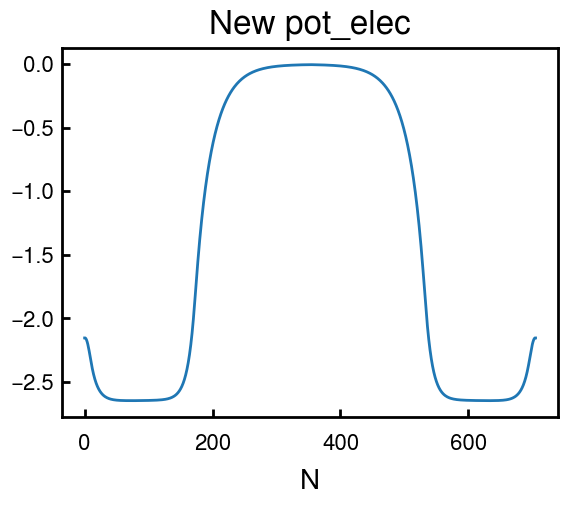

In [87]:
## SINGLE --> DOUBLE WA
filename = 'W_a040c010_x200s002.dat' #Nx = 100, dx = 17.0/150
dx = 17/150
new_Lx = 80
N = round(new_Lx / dx)

names = ['*', 'w1','w2','w3','w4','w5', '**', 'wb', 'eta', 'pot_elec']
df = pd.read_csv(GIT+filename, sep='\s+', skiprows=0, names=names)
# display(df)

if N > 2*len(df.index): 
    rem = ['['] + [1.00]*5 + [']'] + [-1.00]*2 + [0.00]
    rem = pd.DataFrame([rem for i in range(N-2*len(df.index))], columns=names)
    new = pd.concat([df, rem, df.iloc[::-1]], ignore_index=True)
else: 
    shave = df.iloc[0:round(N/2),:]
    new = pd.concat([shave, shave.iloc[::-1]], ignore_index=True)
    
if N == len(new.index): 
    print('Success: {:d} == {:d}.'.format(N, len(new.index)))
    new.to_csv('./imgs/W_sym{}.dat'.format(new_Lx), sep='\t', float_format='%10.5e', header=False, index=False)
else:
    print('Fail: {:d} N versus {:d} New'.format(N, len(new.index)))
    
if True:
    plt.plot(new.pot_elec)
    plt.title('New pot_elec')
    plt.xlabel('N')

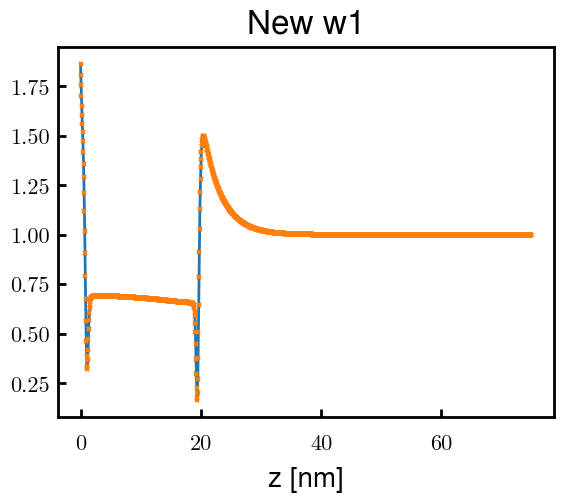

In [140]:
## SINGLE dx1 --> dx2
from scipy.interpolate import CubicSpline
filename = 'W_a040c010_x200s002.dat' #Nx = 75, dx = 17.0/150
dx1 = 17.0/150 # Old
dx2 = 0.05 # New
Lx = 75
Nx1, Nx2 = round(Lx/dx1), round(Lx/dx2)

x1 = np.arange(0, Lx, dx1)
x2 = np.arange(0, Lx, dx2)

names = ['*', 'w1','w2','w3','w4','w5', '**', 'wb', 'eta', 'pot_elec']
df = pd.read_csv(GIT+filename, sep='\s+', skiprows=0, names=names)

if True: 
    test_frame = df.w1
    cs = CubicSpline(x1, test_frame)
    plt.plot(x1, test_frame)
    plt.plot(x2, cs(x2), 'x', markerfacecolor='w', ms=3)

    plt.title('New w1')
    plt.xlabel('z [nm]')
    tjy.ticks()
    plt.show()

A = []
for i in [1, 2, 3, 4, 5, 7, 8, 9]:
    cs = CubicSpline(x1, df.iloc[:, i])
    A = [*A, cs(x2)]
fill = np.array(['[']*(Nx2))
A = [fill, A[0], A[1], A[2], A[3], A[4], fill, A[5], A[6], A[7]]
new = pd.DataFrame(A).transpose()
new.to_csv('./imgs/W_dx{}.dat'.format(dx2*100), sep='\t', float_format='%10.5e', header=False, index=False)